# Demand Time Series

In [299]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [327]:
# загружаем данные
ts_retail = pd.read_csv('./train_kaggle.csv', sep=',')

ts_retail.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN


In [328]:
ts_retail_test = pd.read_csv('./test_kaggle.csv', sep=',')

ts_retail_test.head()

,id,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,0,1,1,23.05.2016,1.0,NaN,128.98,119.6
1,1,1,1,24.05.2016,NaN,NaN,128.98,NaN
2,2,1,1,25.05.2016,NaN,NaN,131.70,NaN
3,3,1,1,26.05.2016,NaN,NaN,131.70,NaN
4,4,1,1,27.05.2016,NaN,NaN,131.70,NaN


In [329]:
# добавим заглушечный столбец
ts_retail.insert(0, 'id', -1) 

In [330]:
# объединим таблицы
data = pd.concat([ts_retail, ts_retail_test], axis=0)

In [331]:
data

,id,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,-1,1,1,01.01.2015,NaN,22.0,163.78,NaN
1,-1,1,1,02.01.2015,NaN,41.0,163.78,NaN
2,-1,1,1,03.01.2015,NaN,35.0,163.78,NaN
3,-1,1,1,04.01.2015,NaN,72.0,163.78,NaN
4,-1,1,1,05.01.2015,NaN,25.0,163.78,NaN
...,...,...,...,...,...,...,...,...
5965,5965,110,2,15.06.2016,NaN,NaN,133.06,NaN
5966,5966,110,2,16.06.2016,NaN,NaN,133.06,NaN
5967,5967,110,2,17.06.2016,NaN,NaN,133.06,NaN
5968,5968,110,2,18.06.2016,NaN,NaN,133.06,NaN


In [332]:
# добавление базовых фичей
def process(data):
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
  data.set_index(['Date'], inplace=True)
  data['Promo'] = data['Promo'].fillna(0)
  data.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
  data['Regular_Price'] = data['Regular_Price'].ffill().bfill()
  data.reset_index().set_index(['Date'], inplace=True)

  # add actual price (promo price when promo occurred or regular price otherwise)
  data['Actual_Price'] = data['Promo_Price'].combine_first(data['Regular_Price'])
  data['Promo_percent'] = (1 - (data['Actual_Price'] / data['Regular_Price']))
  data = data.drop('Promo_Price', axis=1)
  data = data.drop('Regular_Price', axis=1)

  data.reset_index(inplace=True)
  data["weekday"] = data['Date'].dt.weekday
  data["monthday"] = data['Date'].dt.day
  data["month"] = data['Date'].dt.month
  data['is_weekend'] = data['weekday'].isin([5, 6]) * 1
  data['month_period'] = 0
  data.loc[data['monthday'] >= 15, 'month_period'] = 1

  ## base feature

  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])
  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['demand_expanding_mean'].apply(lambda x: x.shift(14))


  return data

In [333]:
data = process(data)

In [334]:
data

,Date,id,Store_id,SKU_id,Promo,Demand,Actual_Price,Promo_percent,weekday,monthday,month,is_weekend,month_period,demand_expanding_mean
0,2015-01-01,-1,1,1,0.0,22.0,163.78,0.0,3,1,1,0,0,NaN
1,2015-01-02,-1,1,1,0.0,41.0,163.78,0.0,4,2,1,0,0,NaN
2,2015-01-03,-1,1,1,0.0,35.0,163.78,0.0,5,3,1,1,0,NaN
3,2015-01-04,-1,1,1,0.0,72.0,163.78,0.0,6,4,1,1,0,NaN
4,2015-01-05,-1,1,1,0.0,25.0,163.78,0.0,0,5,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-15,5965,110,2,0.0,NaN,133.06,0.0,2,15,6,0,1,NaN
92882,2016-06-16,5966,110,2,0.0,NaN,133.06,0.0,3,16,6,0,1,NaN
92883,2016-06-17,5967,110,2,0.0,NaN,133.06,0.0,4,17,6,0,1,NaN
92884,2016-06-18,5968,110,2,0.0,NaN,133.06,0.0,5,18,6,1,1,NaN


In [335]:
from ipywidgets import IntProgress

def calc_rolling(data_preag_filled, group_col, date_col, method, w):
  ## calc rolling stats
  lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
      apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

  ## return DataFrame with rolled columns from target_vars
  return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):
  lf_df = lf_df_filled.groupby(
      level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
  lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

  ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
  return lf_df


def generate_lagged_features(
      data: pd.DataFrame,
      id_cols: list = ['SKU_id', 'Store_id'],
      date_col: str = 'Date',
      lags: list = [7, 14, 21, 28],
      windows: list = ['7D', '14D', '28D', '56D'],
      agg_methods: list = ['mean', 'median']):

  data = data.sort_values(date_col)
  out_df = deepcopy(data)
  dates = [min(data[date_col]), max(data[date_col])]

  total = len(target_cols) * len(lags) * len(windows) * len(agg_methods)
  progress = IntProgress(min=0, max=total)
  display(progress)

  group_col = id_cols + [date_col]
  for lag in lags:
    for w in windows:
      for method in agg_methods:
          rolling_filled = calc_rolling(data,
                                        group_col, date_col,
                                        method, w)

          ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
          rolling = shift(rolling_filled, group_col, date_col,
                          lag)

          method_name = method.__name__ if type(
              method) != str else method

          
          new_name = "{0}_lag{1}d_w{2}_key{3}_ag{4}".format('Demand', lag, w, '_'.join(id_cols), method_name)

          out_df[new_name] = rolling['Demand']
          progress.value += 1

  return out_df


In [336]:
id_cols = ['SKU_id']
date_col = 'Date'

In [337]:
data_lagged_features = generate_lagged_features(data 
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [28, 35, 42, 56]
                    , windows = ['21D', '28D']
                    , agg_methods = ['mean', 'median']
                    )

IntProgress(value=0, max=16)

Я пробовал обучить модели с лаговыми и без лаговых фичей. 

Первоначально для генерации лаговых фичей я использовал функцию из семинара, пытался подобрать параметры, но получал результаты хуже чем модели обученные только на базовых фичах. 

Я модифицировал функцию генерации лаговых фичей, убрав evm,preaggs, dynamic_filters и получил лучшие результаты. При этом наилучшие результаты достигнуты при следующих параметрах: 
- lags = [28, 35, 42, 56]
- windows = ['21D', '28D']
- agg_methods = ['mean', 'median']

In [342]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

30


Index(['Date', 'id', 'Store_id', 'SKU_id', 'Promo', 'Demand', 'Actual_Price',
       'Promo_percent', 'weekday', 'monthday', 'month', 'is_weekend',
       'month_period', 'demand_expanding_mean',
       'Demand_lag28d_w21D_keySKU_id_agmean',
       'Demand_lag28d_w21D_keySKU_id_agmedian',
       'Demand_lag28d_w28D_keySKU_id_agmean',
       'Demand_lag28d_w28D_keySKU_id_agmedian',
       'Demand_lag35d_w21D_keySKU_id_agmean',
       'Demand_lag35d_w21D_keySKU_id_agmedian',
       'Demand_lag35d_w28D_keySKU_id_agmean',
       'Demand_lag35d_w28D_keySKU_id_agmedian',
       'Demand_lag42d_w21D_keySKU_id_agmean',
       'Demand_lag42d_w21D_keySKU_id_agmedian',
       'Demand_lag42d_w28D_keySKU_id_agmean',
       'Demand_lag42d_w28D_keySKU_id_agmedian',
       'Demand_lag56d_w21D_keySKU_id_agmean',
       'Demand_lag56d_w21D_keySKU_id_agmedian',
       'Demand_lag56d_w28D_keySKU_id_agmean',
       'Demand_lag56d_w28D_keySKU_id_agmedian'],
      dtype='object')

In [343]:
data_lagged_features

,Date,id,Store_id,SKU_id,Promo,Demand,Actual_Price,Promo_percent,weekday,monthday,...,Demand_lag35d_w28D_keySKU_id_agmean,Demand_lag35d_w28D_keySKU_id_agmedian,Demand_lag42d_w21D_keySKU_id_agmean,Demand_lag42d_w21D_keySKU_id_agmedian,Demand_lag42d_w28D_keySKU_id_agmean,Demand_lag42d_w28D_keySKU_id_agmedian,Demand_lag56d_w21D_keySKU_id_agmean,Demand_lag56d_w21D_keySKU_id_agmedian,Demand_lag56d_w28D_keySKU_id_agmean,Demand_lag56d_w28D_keySKU_id_agmedian
0,2015-01-01,-1,1,1,0.0,22.0,163.78,0.000000,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9144,2015-01-01,-1,19,1,0.0,25.0,163.78,0.000000,3,1,...,418.658192,188.0,197.579975,148.0,419.520076,188.0,198.313850,151.0,421.546838,192.0
63037,2015-01-01,-1,39,2,0.0,3.0,135.78,0.000000,3,1,...,4.705962,0.0,5.674728,0.0,4.704123,0.0,5.627439,0.0,4.662563,0.0
63545,2015-01-01,-1,40,2,0.0,0.0,135.78,0.000000,3,1,...,5.716192,0.0,6.545616,3.0,5.715752,0.0,6.511947,3.0,5.685227,0.0
8636,2015-01-01,-1,18,1,0.0,13.0,163.78,0.000000,3,1,...,444.220716,217.0,514.063233,226.0,445.212239,217.0,503.467085,223.0,440.496461,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88231,2016-06-19,1315,47,1,1.0,NaN,125.04,0.073503,6,19,...,39.517367,6.0,51.277179,19.0,39.298387,6.0,50.740138,19.0,38.835298,6.0
91216,2016-06-19,4300,47,2,0.0,NaN,139.86,0.000000,6,19,...,17.764401,6.0,5.050971,3.0,17.764401,6.0,5.050971,3.0,17.764401,6.0
91244,2016-06-19,4328,48,2,0.0,NaN,137.14,0.000000,6,19,...,17.764401,6.0,5.050971,3.0,17.764401,6.0,5.050971,3.0,17.764401,6.0
91160,2016-06-19,4244,45,2,0.0,NaN,139.86,0.000000,6,19,...,23.355583,6.0,5.020496,3.0,23.355583,6.0,5.020496,3.0,23.355583,6.0


## ML Model Training

In [344]:
data_lagged_features_ml = data_lagged_features.set_index(['Date'])

In [345]:
data_lagged_features_ml

,id,Store_id,SKU_id,Promo,Demand,Actual_Price,Promo_percent,weekday,monthday,month,...,Demand_lag35d_w28D_keySKU_id_agmean,Demand_lag35d_w28D_keySKU_id_agmedian,Demand_lag42d_w21D_keySKU_id_agmean,Demand_lag42d_w21D_keySKU_id_agmedian,Demand_lag42d_w28D_keySKU_id_agmean,Demand_lag42d_w28D_keySKU_id_agmedian,Demand_lag56d_w21D_keySKU_id_agmean,Demand_lag56d_w21D_keySKU_id_agmedian,Demand_lag56d_w28D_keySKU_id_agmean,Demand_lag56d_w28D_keySKU_id_agmedian
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-1,1,1,0.0,22.0,163.78,0.000000,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,-1,19,1,0.0,25.0,163.78,0.000000,3,1,1,...,418.658192,188.0,197.579975,148.0,419.520076,188.0,198.313850,151.0,421.546838,192.0
2015-01-01,-1,39,2,0.0,3.0,135.78,0.000000,3,1,1,...,4.705962,0.0,5.674728,0.0,4.704123,0.0,5.627439,0.0,4.662563,0.0
2015-01-01,-1,40,2,0.0,0.0,135.78,0.000000,3,1,1,...,5.716192,0.0,6.545616,3.0,5.715752,0.0,6.511947,3.0,5.685227,0.0
2015-01-01,-1,18,1,0.0,13.0,163.78,0.000000,3,1,1,...,444.220716,217.0,514.063233,226.0,445.212239,217.0,503.467085,223.0,440.496461,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-19,1315,47,1,1.0,NaN,125.04,0.073503,6,19,6,...,39.517367,6.0,51.277179,19.0,39.298387,6.0,50.740138,19.0,38.835298,6.0
2016-06-19,4300,47,2,0.0,NaN,139.86,0.000000,6,19,6,...,17.764401,6.0,5.050971,3.0,17.764401,6.0,5.050971,3.0,17.764401,6.0
2016-06-19,4328,48,2,0.0,NaN,137.14,0.000000,6,19,6,...,17.764401,6.0,5.050971,3.0,17.764401,6.0,5.050971,3.0,17.764401,6.0


In [348]:
# разбиение на трейн и тест датасеты
train = data_lagged_features_ml[data_lagged_features_ml['Demand'].notna()]
test = data_lagged_features_ml[data_lagged_features_ml['Demand'].isna()]

Я пробовал обучать модели, так:
- не делю данные на sku и использую 1 модель
- делю данные для sku1 и sku2 и использую 2 модель
- делю данные на sku и магазины и использую 2*store_id моделей

Лучшие результаты были достигнуты, когда я делил данные для sku1 и sku2 и использовал 2 модели.

In [352]:
# train specific model for each SKU
sku1_train = train[train['SKU_id'] == 1]
sku2_train = train[train['SKU_id'] == 2]

In [353]:
# train specific model for each SKU
sku1_test = test[test['SKU_id'] == 1]
sku2_test = test[test['SKU_id'] == 2]

Я пробовал для обучения три модели:
- catboost
- xgboost
- lightgbm

Лучшие результаты были достигнуты при catboost (learning_rate=0.1, n_estimators=800)

Пробуем catboost

In [354]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [355]:
from catboost import CatBoostRegressor

catbst1 = CatBoostRegressor(learning_rate=0.1, n_estimators=800, loss_function='MAE')
catbst1.fit(sku1_train.drop(['id', 'SKU_id','Demand'], axis=1), sku1_train.Demand)

catbst2 = CatBoostRegressor(learning_rate=0.1, n_estimators=800, loss_function='MAE')

catbst2.fit(sku2_train.drop(['id', 'SKU_id','Demand'], axis=1), sku2_train.Demand)

0:	learn: 227.1211796	total: 75.5ms	remaining: 1m
1:	learn: 216.4156622	total: 134ms	remaining: 53.6s
2:	learn: 205.9699889	total: 167ms	remaining: 44.3s
3:	learn: 197.3762581	total: 210ms	remaining: 41.8s
4:	learn: 190.1912877	total: 244ms	remaining: 38.7s
5:	learn: 184.2251231	total: 280ms	remaining: 37.1s
6:	learn: 179.2706910	total: 317ms	remaining: 35.9s
7:	learn: 174.9090303	total: 351ms	remaining: 34.8s
8:	learn: 171.5396160	total: 394ms	remaining: 34.6s
9:	learn: 168.4951602	total: 435ms	remaining: 34.4s
10:	learn: 165.6907802	total: 489ms	remaining: 35.1s
11:	learn: 163.6236236	total: 534ms	remaining: 35.1s
12:	learn: 161.6255753	total: 577ms	remaining: 34.9s
13:	learn: 159.7738143	total: 623ms	remaining: 35s
14:	learn: 158.2383574	total: 658ms	remaining: 34.5s
15:	learn: 156.7875225	total: 701ms	remaining: 34.3s
16:	learn: 155.3899842	total: 752ms	remaining: 34.6s
17:	learn: 153.9445308	total: 803ms	remaining: 34.9s
18:	learn: 152.5968991	total: 841ms	remaining: 34.6s
19:	lea

In [356]:
def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.show()

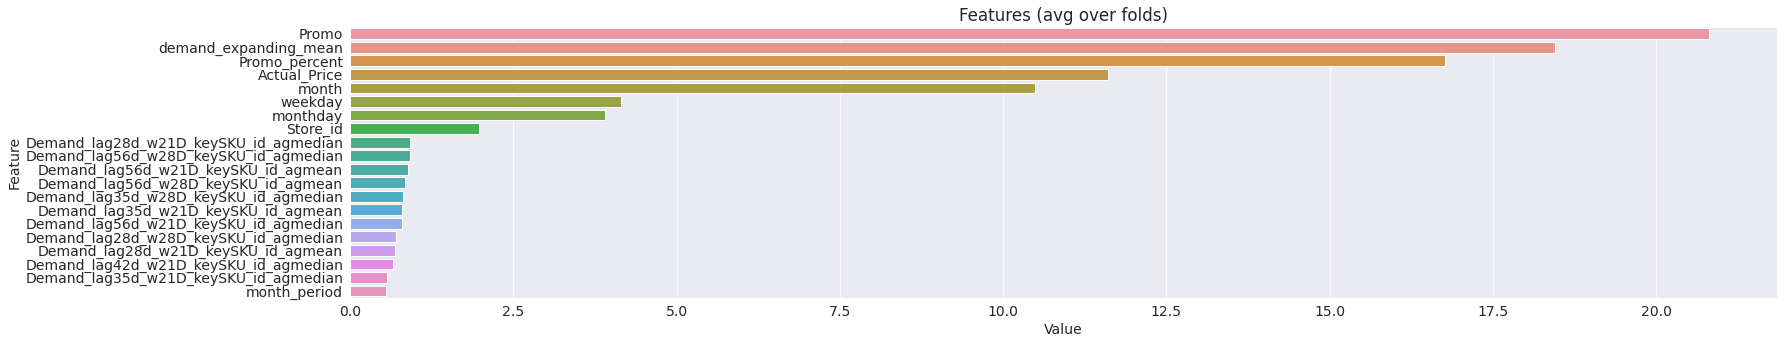

In [357]:
plot_feature_importance(catbst1, sku1_train.drop(['id', 'SKU_id','Demand'], axis=1), num = 20)

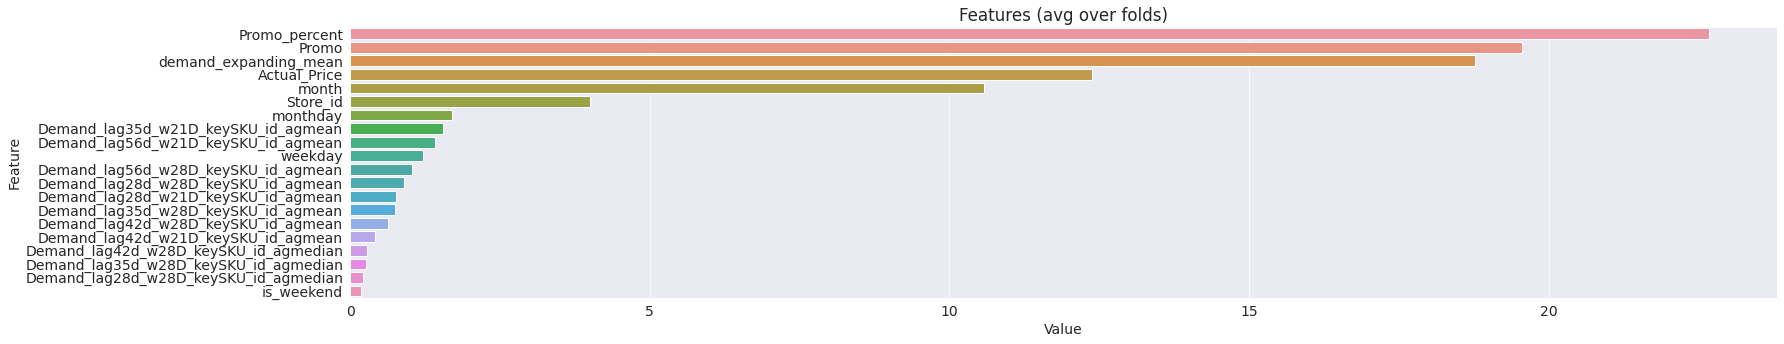

In [358]:
plot_feature_importance(catbst2, sku2_train.drop(['id', 'SKU_id','Demand'], axis=1), num = 20)

Пробуем xgboost

In [ ]:
import xgboost as xg

xgb1 = xg.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5, subsample=0.4)
xgb1.fit(sku1_train.drop(['id', 'SKU_id','Demand'], axis=1), sku1_train.Demand)

xgb2 = xg.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5, subsample=0.4)
xgb2.fit(sku2_train.drop(['id', 'SKU_id','Demand'], axis=1), sku2_train.Demand)

Пробуем lightgbm

In [71]:
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

# without CV
lgbm1 = lgb.LGBMRegressor(learning_rate=0.01,metric='mae', n_jobs=-1)
lgbm1.fit(X = sku1_train.drop(['id', 'SKU_id','Demand'], axis=1), y = sku1_train.Demand)

lgbm2 = lgb.LGBMRegressor(learning_rate=0.01,metric='mae', n_jobs=-1)

lgbm2.fit(X = sku2_train.drop(['id', 'SKU_id','Demand'], axis=1), y = sku2_train.Demand)

LGBMRegressor(learning_rate=0.01, metric='mae')

In [ ]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [ ]:
# Train sets
X_train1 = sku1_train.drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.Demand
X_train2 = sku2_train.drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.Demand

In [ ]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [ ]:
# run TS CV for the sku 1 (if needed)
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape, kwargs)

## Forecast Generation with ML

In [359]:
# Test sets
X_test1 = sku1_test.drop(['SKU_id','Demand'], axis=1)
y_test1 = sku1_test.Demand
X_test2 = sku2_test.drop(['SKU_id', 'Demand'], axis=1)
y_test2 = sku2_test.Demand

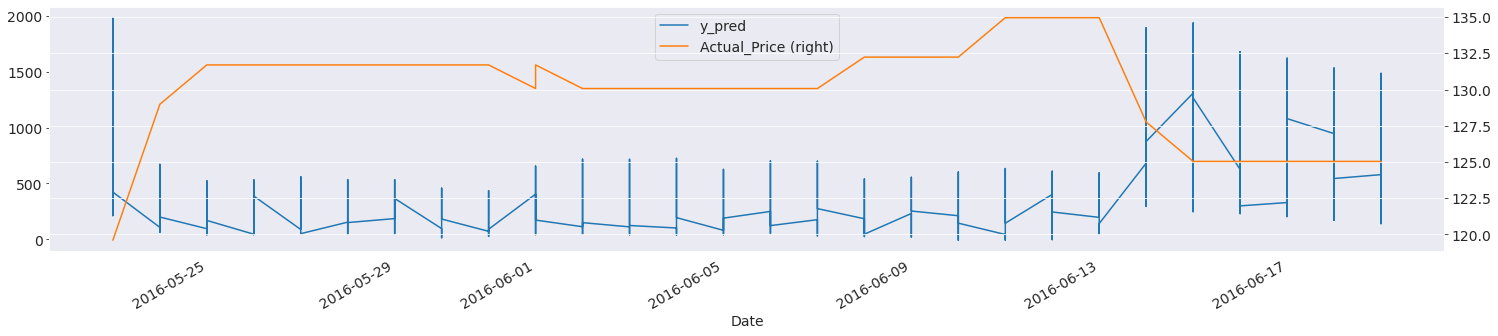

In [360]:
# forecast for sku 1
X_test1['y_pred'] = catbst1.predict(X_test1[X_test1.columns[1:]])
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

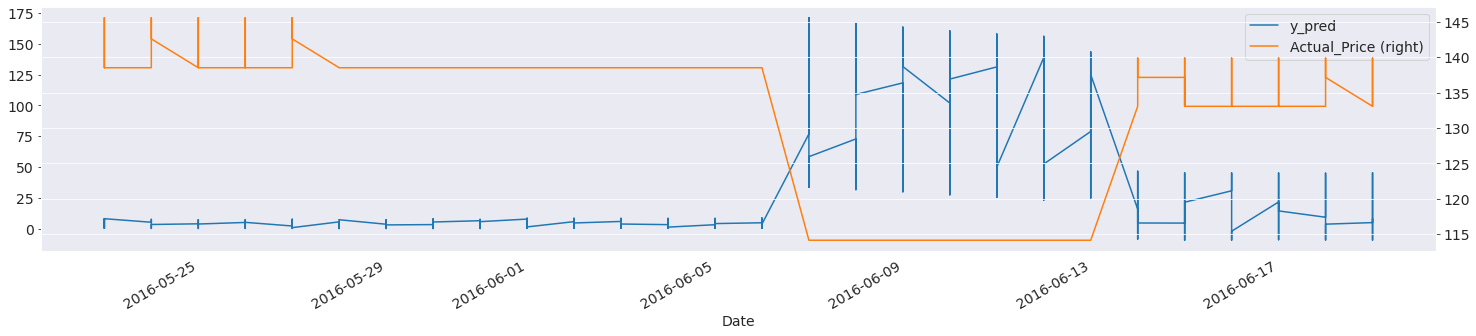

In [361]:
X_test2['y_pred'] = catbst2.predict(X_test2[X_test2.columns[1:]])
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [362]:
result = pd.concat([X_test1.reset_index(), X_test2.reset_index()], sort=False, axis=0).reset_index().sort_values(by=['id'])

In [363]:
# Demand не может быть меньше нуля
result.loc[result['y_pred'] < 0, 'y_pred'] = 0

In [365]:
result[['id', 'y_pred']]

,id,y_pred
102,0,423.192052
187,1,113.848844
279,2,90.925869
394,3,95.010837
427,4,97.709807
...,...,...
5498,5965,5.152040
5558,5966,7.764667
5685,5967,9.180361
5755,5968,9.207404


In [366]:
#  Сохраняем результат
with open('csv_data.csv', 'w') as csv_file:
  result.to_csv(path_or_buf=csv_file, index=False, header=['id', 'Demand'], columns=['id', 'y_pred'])